Raw


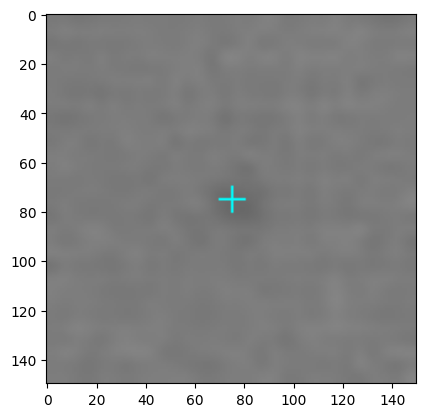

Filtered


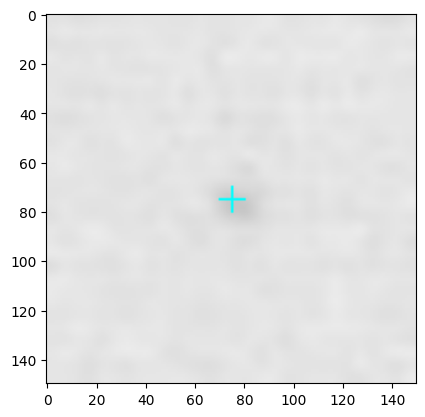

Blurred: 25.632343753043564


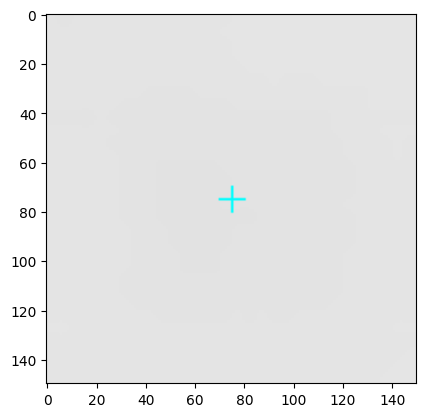

Diff (Float - blurred)


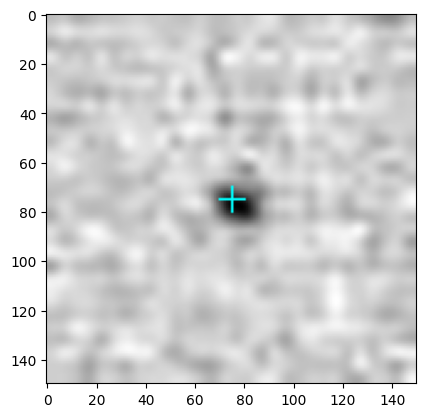

Median


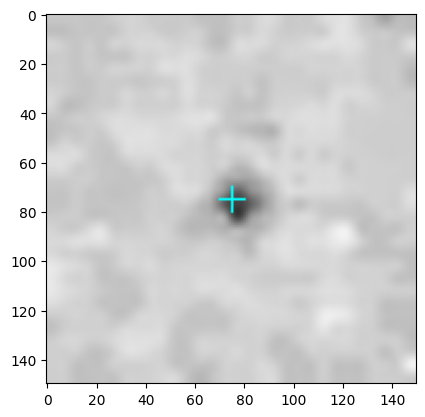

Median filtered


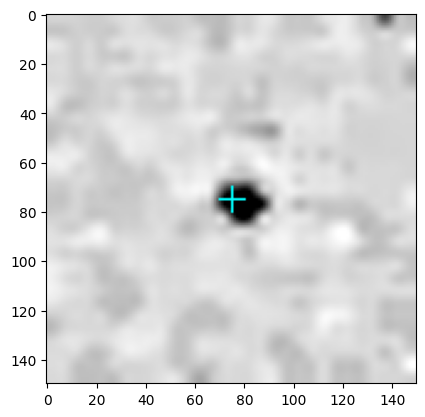

Threshold


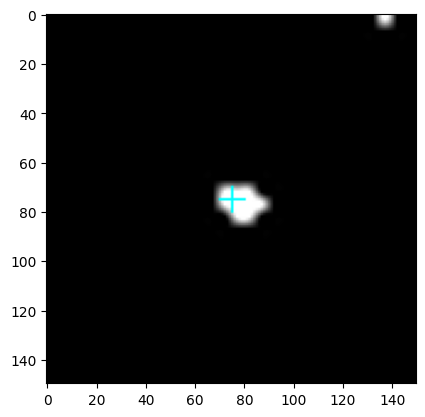

Gaussian


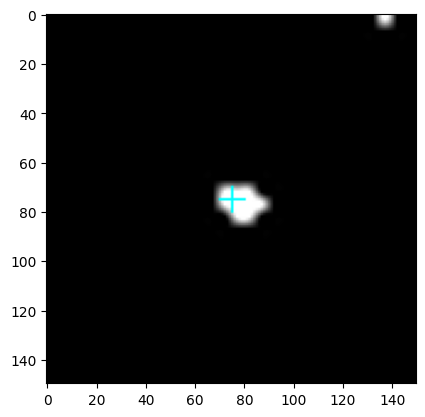

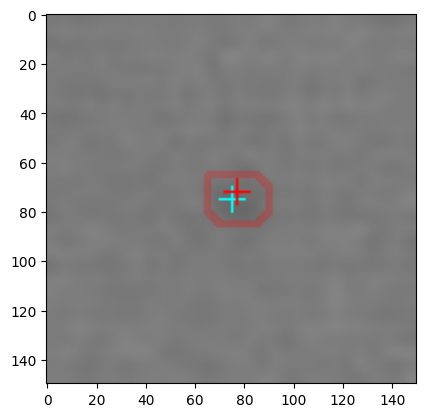

In [30]:
import samtools
import math
import cv2
import numpy as np

sample_frame = cv2.imread('sample_frame.jpg')

x_float = 182.1416321
y_float = 236.0445604
x_start = int(x_float-15+0.5)
y_start = int(y_float-15+0.5)
x_end = int(x_float+15+0.5)
y_end = int(y_float+15+0.5)

subimage = sample_frame[y_start:y_end, x_start:x_end]

print('Raw')
samtools.show_crop(subimage, 15)
krad = 17
gsigma =10
img_wt=3.6
blur_wt=2.9
gamma = 0.1
subimage_filtered = samtools.filter_image(subimage, gamma=gamma)
print('Filtered')
samtools.show_crop(subimage_filtered, 15)

subimage_float = subimage_filtered.astype(np.float32)
radius = int(1.5 * 5 + 0.5) #5 might be too high
sigma = radius * math.sqrt(2 * math.log(255)) - 1
subimage_blurred = cv2.GaussianBlur(subimage_float, (2 * radius + 1, 2 * radius + 1), sigma)
# subimage_blurred = cv2.GaussianBlur(subimage_float, (2 * radius + 1, radius + 1), sigma)
print(f'Blurred: {sigma}')
samtools.show_crop(subimage_blurred, 15)

subimage_diff = subimage_float-subimage_blurred
subimage_diff = cv2.normalize(subimage_diff, None, 0,255,cv2.NORM_MINMAX).astype(np.uint8)
print('Diff (Float - blurred)')
samtools.show_crop(subimage_diff, 15)

# Median
subimage_median = cv2.medianBlur(subimage_diff, 3)
print('Median')
samtools.show_crop(subimage_median, 15)

# LUT
subimage_median = samtools.filter_image(subimage_median, krad=3)
print('Median filtered')
samtools.show_crop(subimage_median, 15)

# Thresholding
threshold=6
subimage_median = cv2.cvtColor(subimage_median, cv2.COLOR_BGR2GRAY)
minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(subimage_median)
thres = 0.5 * minVal + 0.5 * np.mean(subimage_median) + threshold * 0.01 * 255
ret, subimage_threshold =  cv2.threshold(subimage_median, thres, 255, cv2.THRESH_BINARY_INV)
print('Threshold')
samtools.show_crop(subimage_threshold, 15)

# Gaussian blur
subimage_gaussthresh = cv2.GaussianBlur(subimage_threshold, (3,3), 1.3)
print('Gaussian')
samtools.show_crop(subimage_threshold, 15)

# Find contours
contours, hierarchy = cv2.findContours(subimage_gaussthresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE, offset=(x_start,y_start))
contours_im = [contour-[x_start, y_start] for contour in contours]

# Find closest contour
dist = 1000
best_index = -1
detected_centers = {}
for i, cnt in enumerate(contours):
    detected_center, circle_radius = cv2.minEnclosingCircle(cnt)
    distTmp = math.sqrt((x_float - detected_center[0])**2 + (y_float - detected_center[1])**2)
    detected_centers[round(distTmp, 4)] = detected_center
    if distTmp < dist:
        best_index = i
        dist = distTmp

# Display contour on raw image
if best_index >= 0:
    detected_center, _ = cv2.minEnclosingCircle(contours[best_index])
    detected_center_im, _ = cv2.minEnclosingCircle(contours_im[best_index])
    samtools.show_crop(subimage, 15, contours = [contours_im[best_index]], detected_marker = detected_center_im)

# working_dir = 'C:/Users/sjcde/OneDrive/Documents/AxoChewing'

# samtools.autocorrect(working_dir=working_dir)